# Crash Reporting US | Exploratory Analysis
Goal: describe the most common conditions and patterns present in crash records and explore how factors relate to crash severity.


## 1. Introduction
### 1.1 Context for readers
Traffic crashes are a major public safety issue that lead to injuries, fatalities, and economic losses.

### 1.2 Motivation
Understanding common crash environments and driver/vehicle factors can inform safety awareness and policy discussions.

### 1.3 Research questions
1) Accident hotspots: which road types appear most often in crash records?
2) Time patterns: when do crashes occur most frequently?
3) Collision causes: what driver/vehicle factors are most common in crashes?
4) Environmental impacts: how do weather, surface, light, and traffic control relate to severity?
5) Vehicle conditions: do vehicle age and size show different damage patterns?


## 2. Data
### 2.1 Technical description
Dataset: ?Crash Reporting - Drivers Data? (Montgomery County, MD; ACRS system).
We use the CSV file provided with the project.


In [298]:
import pandas as pd
import numpy as np

df = pd.read_csv("crash_data.csv", encoding="latin1", low_memory=False)
df.head(3)


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3170003V,240000438,Montgomery County Police,Property Damage Crash,01/03/2024 14:55,NaN,NaN,NaN,NaN,IN FRONT OF 18900 BIRDSEYE DR,...,0,No,No,2017,LEXUS,SUV,NO MISUSE,39.165005,-77.249310,"(39.16500483, -77.24931)"
1,MCP3254003K,230072050,Montgomery County Police,Injury Crash,12/16/2023 12:36:00 PM,Maryland (State),GERMANTOWN RD,County,MIDDLEBROOK RD,NaN,...,35,No,No,2010,TOYT,PRIUS,NO MISUSE,39.178776,-77.267190,"(39.17877577, -77.26718974)"
2,EJ7887003Q,230074270,Gaithersburg Police Depar,Injury Crash,12/29/2023 12:00:00 PM,Maryland (State),GREAT SENECA HWY,Municipality,KENTLANDS BLVD,NaN,...,35,No,No,2021,SUBARU,FORRESTER,NO MISUSE,39.123574,-77.231769,"(39.12357374, -77.231769)"


In [299]:
# Dataset overview
overview = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=["number"]).shape[1]],
    "n_categorical": [df.select_dtypes(include=["object"]).shape[1]],
})
overview


,n_rows,n_cols,n_numeric,n_categorical
0,167330,41,4,37


### 2.2 Research plan
We structure the analysis around five questions, linking each to relevant variables and outcomes.


In [300]:
plan = pd.DataFrame({
    "No.": [1,2,3,4,5],
    "Research Question": [
        "Accident hotspots",
        "Time patterns",
        "Collision causes",
        "Environmental impacts",
        "Vehicle conditions"
    ],
    "Key Variables": [
        "Route Type, Cross-Street Type",
        "Crash Date/Time",
        "Driver Substance Abuse, Driver Distracted By, Vehicle Movement, Equipment Problems",
        "Weather, Surface Condition, Light, Traffic Control, Speed Limit",
        "Vehicle Year, Vehicle Body Type"
    ],
    "Outcomes": [
        "N/A",
        "N/A",
        "Vehicle Damage Extent",
        "Injury Severity, Vehicle Damage Extent",
        "Vehicle Damage Extent"
    ]
})
plan


,No.,Research Question,Key Variables,Outcomes
0,1,Accident hotspots,"Route Type, Cross-Street Type",N/A
1,2,Time patterns,Crash Date/Time,N/A
2,3,Collision causes,"Driver Substance Abuse, Driver Distracted By, ...",Vehicle Damage Extent
3,4,Environmental impacts,"Weather, Surface Condition, Light, Traffic Con...","Injury Severity, Vehicle Damage Extent"
4,5,Vehicle conditions,"Vehicle Year, Vehicle Body Type",Vehicle Damage Extent


### 2.3 Data preparation and missing values
- Remove full-row duplicates.
- Drop identifiers and highly-missing or irrelevant fields.
- Convert crash time to datetime and derive time features.
- Clean abnormal Vehicle Year values (e.g., 0, 9999, future years).
- Treat missing categories as ?Missing/Unknown? for key categorical fields.


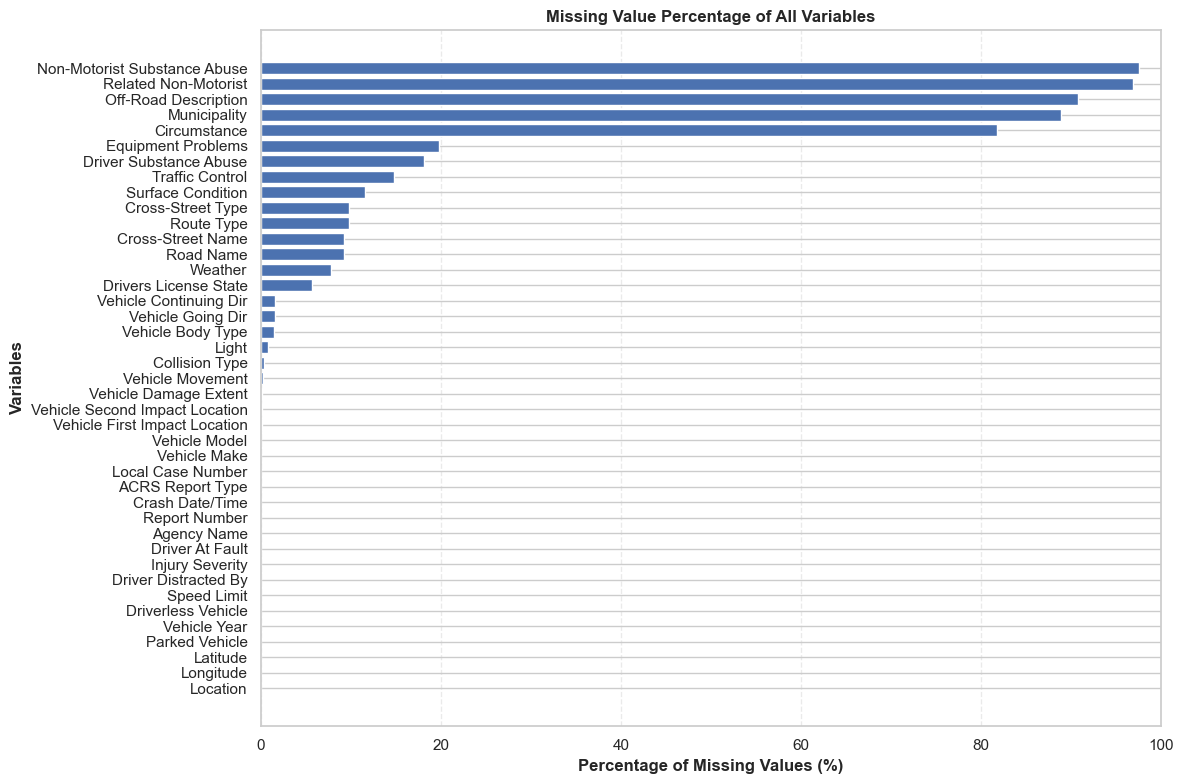

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) Missing % per column
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

# Optional: plot only columns with at least 1% missing
# missing_pct = missing_pct[missing_pct > 1]

# 2) Plot (horizontal bars)
plt.figure(figsize=(12, 8))
plt.barh(missing_pct.index, missing_pct.values)
plt.gca().invert_yaxis()  # largest on top

plt.title("Missing Value Percentage of All Variables")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Variables")
plt.xlim(0, 100)

# Grid similar vibe to ggplot
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# # Missingness pattern (sample)
# sample = df.sample(500, random_state=42)
# plt.figure(figsize=(8,4))
# sns.heatmap(sample.isna(), cbar=False)
# plt.title("Missingness pattern (sample of 500 rows)")
# plt.xlabel("Variables")
# plt.ylabel("Rows")
# plt.tight_layout()
# plt.show()


In [302]:
# Remove exact duplicates
df = df.drop_duplicates()

# Drop identifiers and high-missing or irrelevant columns
drop_cols = [
    "Report Number", "Local Case Number", "Parked Vehicle", "Driverless Vehicle", "Driver At Fault",
    "Non-Motorist Substance Abuse", "Related Non-Motorist", "ACRS Report Type", "Agency Name", "Latitude", "Longitude",
    "Off-Road Description", "Municipality", "Circumstance", "Collision Type", "Drivers License State", "Vehicle Model",
    "Location", "Road Name", "Cross-Street Name", "Vehicle Going Dir", "Vehicle Continuing Dir" , "Vehicle First Impact Location" , "Vehicle Second Impact Location"
    
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Missing/Unknown for key categoricals
missing_as_category = [
    "Weather", "Surface Condition", "Light", "Traffic Control",
    "Driver Substance Abuse", "Driver Distracted By", "Equipment Problems",
    "Vehicle Movement", "Vehicle Body Type", "Vehicle Damage Extent",
    "Route Type", "Cross-Street Type", "Injury Severity"
]
for c in missing_as_category:
    if c in df.columns:
        df[c] = df[c].astype("object").fillna("Missing/Unknown")


overview_after = pd.DataFrame({
    "n_rows": [len(df)],
    "n_cols": [df.shape[1]],
    "n_numeric": [df.select_dtypes(include=["number"]).shape[1]],
    "n_categorical": [df.select_dtypes(include=["object"]).shape[1]],
})
overview_after

,n_rows,n_cols,n_numeric,n_categorical
0,167326,17,2,15


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\1334882079.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  missing_pct_refined = (df.applymap(lambda x: x == "Missing/Unknown").mean() * 100).sort_values(ascending=False)


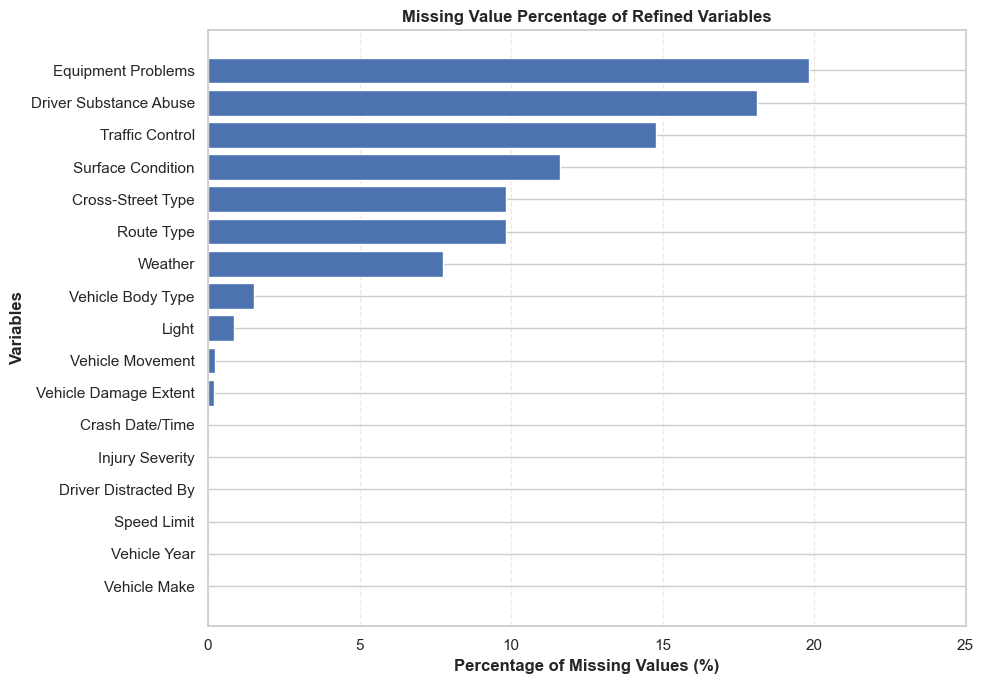

In [303]:
import matplotlib.pyplot as plt

missing_pct_refined = (df.applymap(lambda x: x == "Missing/Unknown").mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(missing_pct_refined.index, missing_pct_refined.values)
plt.gca().invert_yaxis()

plt.title("Missing Value Percentage of Refined Variables")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Variables")
plt.xlim(0, 25)  # matches your plot scale

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\2371908037.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  miss = df_s.applymap(lambda x: str(x).strip() == "Missing/Unknown")


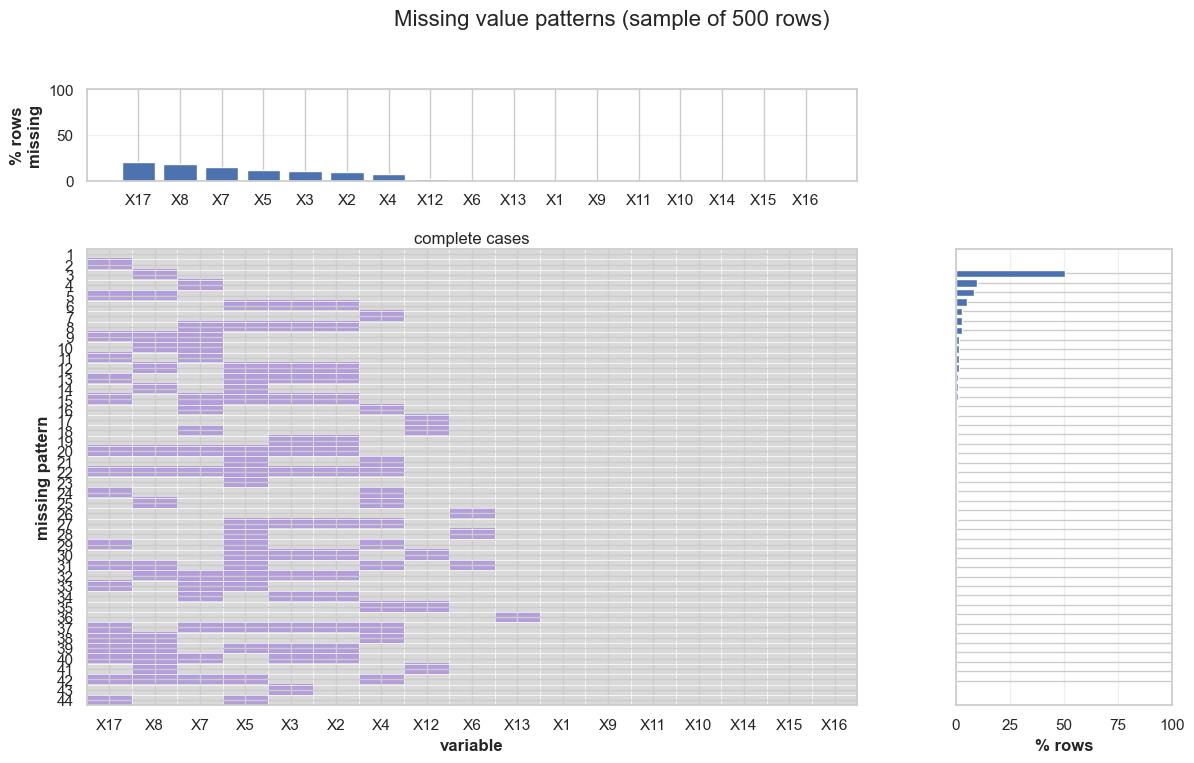

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

vars_order = [
    "Crash Date/Time",
    "Route Type",
    "Cross-Street Type",
    "Weather",
    "Surface Condition",
    "Light",
    "Traffic Control",
    "Driver Substance Abuse",
    "Injury Severity",
    "Driver Distracted By",
    "Vehicle Damage Extent",
    "Vehicle Body Type",
    "Vehicle Movement",
    "Speed Limit",
    "Vehicle Year",
    "Vehicle Make",
    "Equipment Problems",
]

var_to_num = {name: i + 1 for i, name in enumerate(vars_order)}

# ----------------------------
# Sample data
# ----------------------------
sample_n = 500
df_s = df[vars_order].sample(n=sample_n)

# Boolean missingness mask
miss = df_s.applymap(lambda x: str(x).strip() == "Missing/Unknown")

# ----------------------------
# 1) SORT VARIABLES by % missing
# ----------------------------
missing_pct = miss.mean(axis=0) * 100
missing_pct = missing_pct.sort_values(ascending=False)

vars_sorted = missing_pct.index.tolist()

# Reorder mask to match sorted variables
miss = miss[vars_sorted]

# ----------------------------
# 2) SORT MISSING PATTERNS by % rows
# ----------------------------
patterns = miss.apply(lambda r: tuple(r.values), axis=1)
pattern_counts = patterns.value_counts().sort_values(ascending=False)

pattern_matrix = np.array(pattern_counts.index.tolist(), dtype=bool)
pattern_freq_pct = (pattern_counts.values / len(df_s)) * 100

# ----------------------------
# 3) Plot
# ----------------------------
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    height_ratios=[1, 5],
    width_ratios=[5, 1.4],
    hspace=0.25, wspace=0.2
)

ax_top = fig.add_subplot(gs[0, 0])
ax_mid = fig.add_subplot(gs[1, 0])
ax_right = fig.add_subplot(gs[1, 1])

# ---- Top bar chart (sorted by % missing)
x = np.arange(len(vars_sorted))
ax_top.bar(x, missing_pct.values)
ax_top.set_ylim(0, 100)
ax_top.set_xticks(x)
ax_top.set_xticklabels([f"X{var_to_num[v]}" for v in vars_sorted])
ax_top.set_ylabel("% rows\nmissing")
ax_top.grid(axis="y", alpha=0.3)

# ---- Heatmap (aligned with sorted variables)
img = pattern_matrix.astype(int)
cmap = ListedColormap(["#d9d9d9", "#b39ddb"])

ax_mid.imshow(img, aspect="auto", interpolation="nearest", cmap=cmap)

ax_mid.set_xticks(x)
ax_mid.set_xticklabels([f"X{var_to_num[v]}" for v in vars_sorted])
ax_mid.set_yticks(np.arange(len(pattern_counts)))
ax_mid.set_yticklabels(np.arange(1, len(pattern_counts) + 1))
ax_mid.set_xlabel("variable")
ax_mid.set_ylabel("missing pattern")

ax_mid.text(
    0.5, 1.04, "complete cases",
    transform=ax_mid.transAxes,
    ha="center", va="top",
    fontsize=12
)

ax_mid.set_xticks(np.arange(-0.5, len(vars_sorted), 1), minor=True)
ax_mid.set_yticks(np.arange(-0.5, len(pattern_counts), 1), minor=True)
ax_mid.grid(which="minor", color="white", linewidth=0.5)
ax_mid.tick_params(which="minor", bottom=False, left=False)

# ---- Right bar chart (sorted by % rows)
y = np.arange(len(pattern_counts))
ax_right.barh(y, pattern_freq_pct)
ax_right.invert_yaxis()
ax_right.set_xlim(0, 100)
ax_right.set_xlabel("% rows")
ax_right.set_yticks(y)
ax_right.set_yticklabels([])
ax_right.grid(axis="x", alpha=0.3)

fig.suptitle("Missing value patterns (sample of 500 rows)", fontsize=16)
plt.show()


## 3. Results
### 3.1 Accident Hotspots


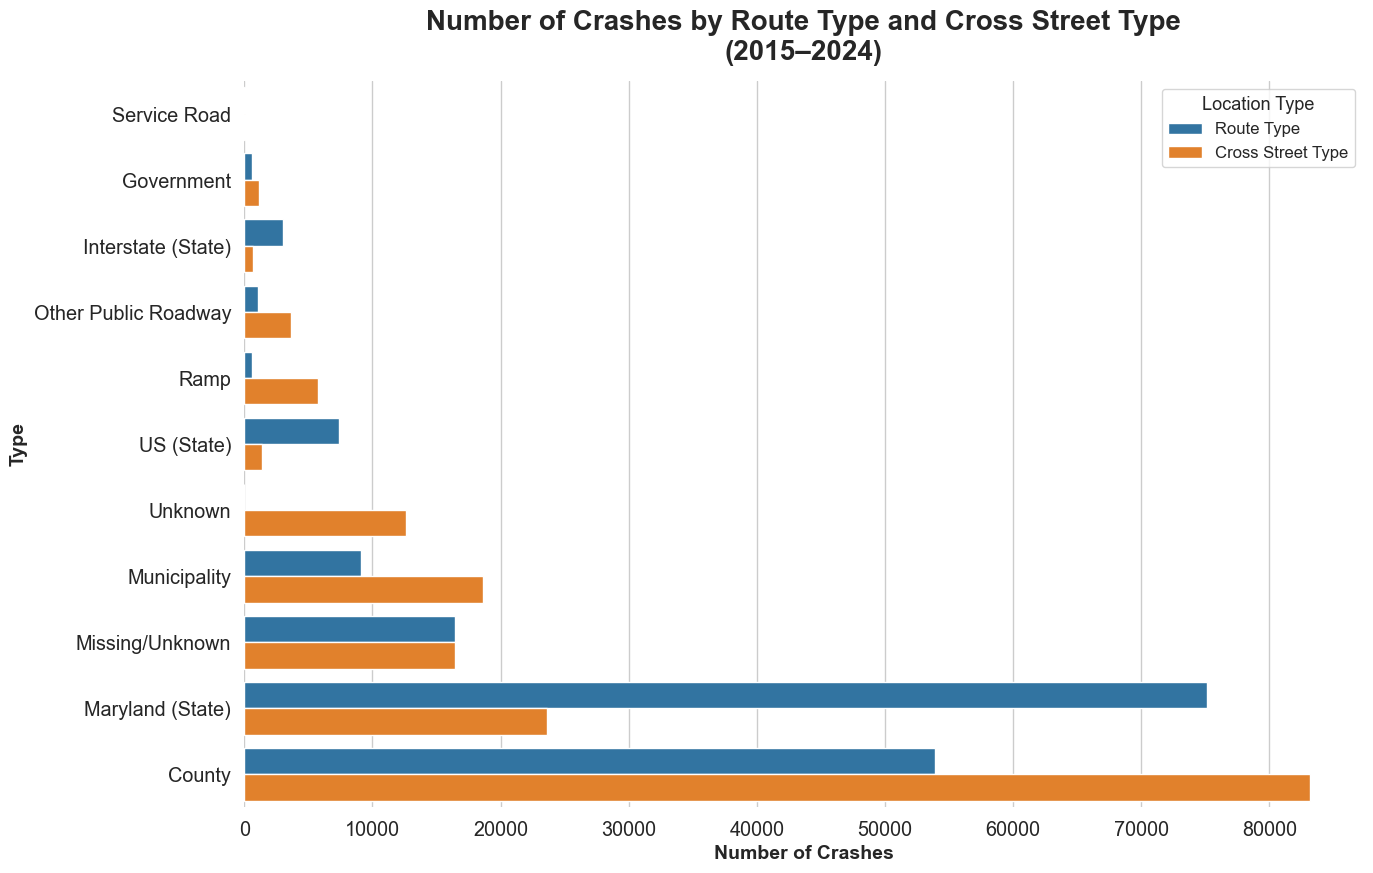

In [305]:

route_counts = (
    df["Route Type"]
    .value_counts()
    .reset_index()
)
route_counts.columns = ["type", "count"]
route_counts["location"] = "Route Type"

cross_counts = (
    df["Cross-Street Type"]
    .value_counts()
    .reset_index()
)
cross_counts.columns = ["type", "count"]
cross_counts["location"] = "Cross Street Type"

plot_df = pd.concat([route_counts, cross_counts], ignore_index=True)


plot_df["type"] = pd.Categorical(
    plot_df["type"],
    categories=plot_df.groupby("type")["count"].sum().sort_values().index,
    ordered=True
)


sns.set_theme(style="whitegrid", font_scale=1.3)

plt.figure(figsize=(14, 9))

palette = {
    "Route Type": "#1f77b4",        # blue
    "Cross Street Type": "#ff7f0e"  # orange
}

ax = sns.barplot(
    data=plot_df,
    x="count",
    y="type",
    hue="location",
    palette=palette
)

ax.set_title(
    "Number of Crashes by Route Type and Cross Street Type\n(2015–2024)",
    fontsize=20,
    weight="bold",
    pad=15
)
ax.set_xlabel("Number of Crashes", fontsize=14)
ax.set_ylabel("Type", fontsize=14)

ax.legend(title="Location Type", fontsize=12, title_fontsize=13)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



### 3.2 Time Patterns
#### 3.2.1 Yearly & Seasonal Patterns


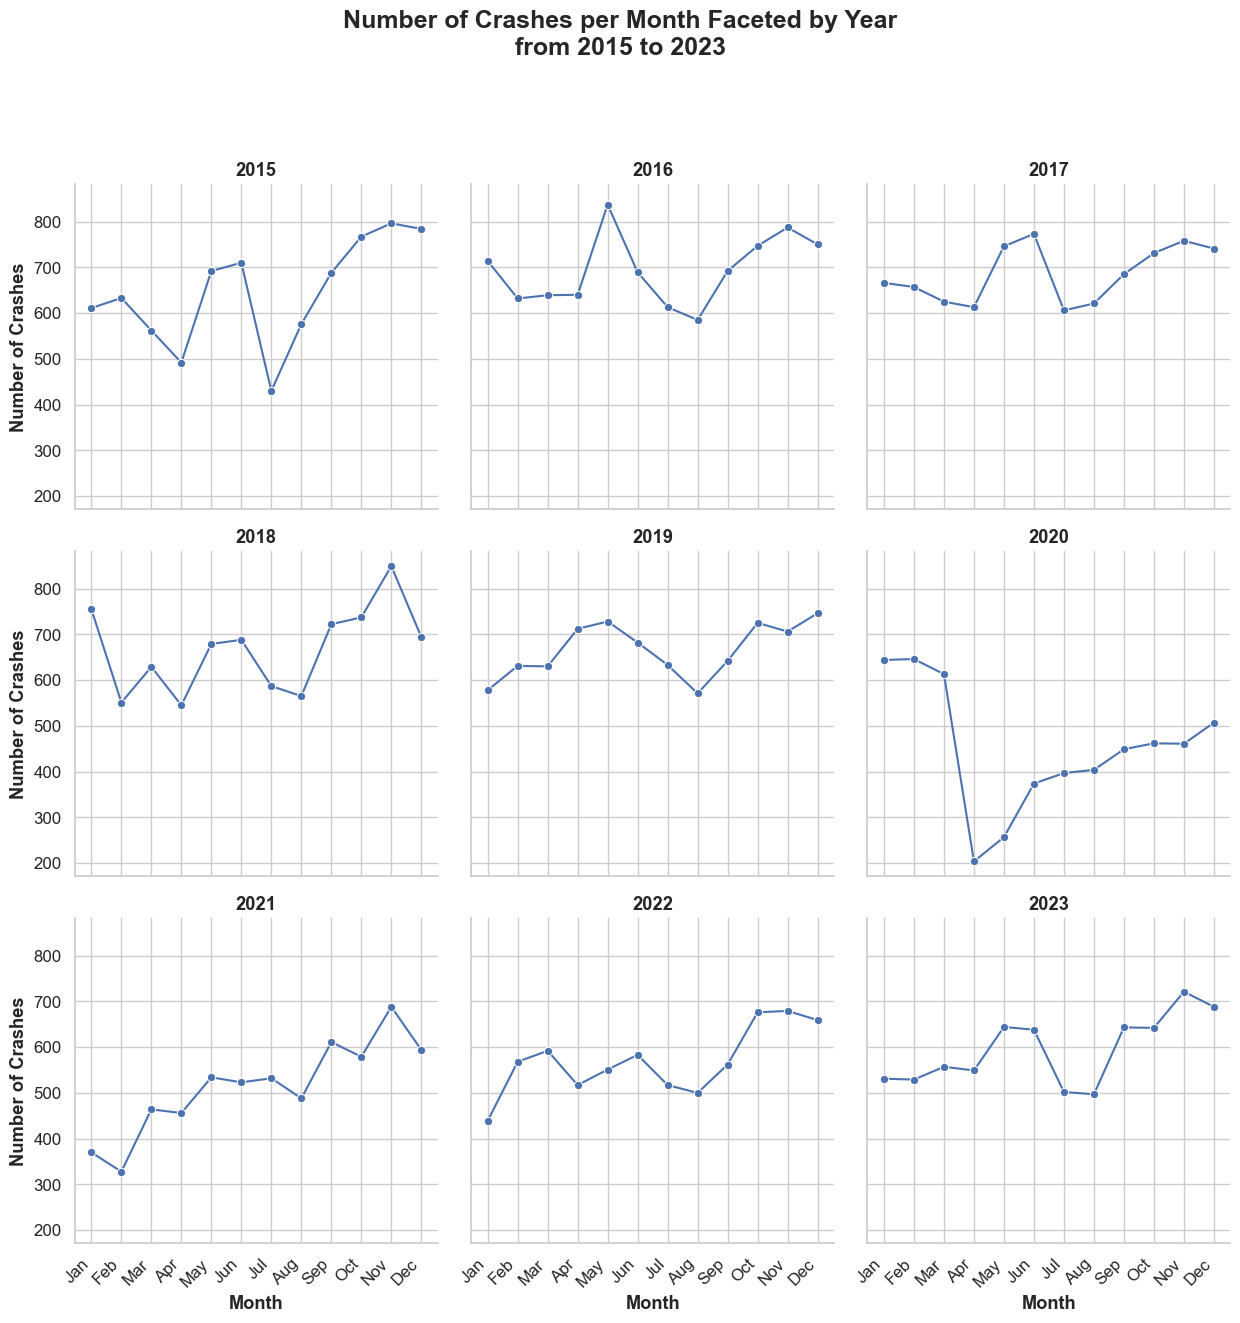

In [306]:

DATE_COL = "Crash Date/Time"
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# Keep only rows with valid dates
df = df.dropna(subset=[DATE_COL])

# ----------------------------
# Extract Year + Month
# ----------------------------
df["Year"] = df[DATE_COL].dt.year
df["Month"] = df[DATE_COL].dt.month

# Filter to 2015–2023 (change if needed)
df = df[(df["Year"] >= 2015) & (df["Year"] <= 2023)]

# ----------------------------
# Count crashes per (Year, Month)
# ----------------------------
monthly_counts = (
    df.groupby(["Year", "Month"])
      .size()
      .reset_index(name="Crashes")
)

# Ensure months are ordered 1..12 and include missing months as zeros
all_years = sorted(monthly_counts["Year"].unique())
full_index = pd.MultiIndex.from_product([all_years, range(1, 13)], names=["Year", "Month"])
monthly_counts = (
    monthly_counts.set_index(["Year", "Month"])
                  .reindex(full_index, fill_value=0)
                  .reset_index()
)

# Month labels
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# ----------------------------
# Plot: Faceted line chart by year
# ----------------------------
sns.set_theme(style="whitegrid", font_scale=1.1)

g = sns.FacetGrid(
    monthly_counts,
    col="Year",
    col_wrap=3,        # 9 panels per row (2015–2023 fits nicely)
    height=4.2,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="Month",
    y="Crashes",
    marker="o",
    linewidth=1.5
)

# Axis formatting
g.set_axis_labels("Month", "Number of Crashes")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels, rotation=45, ha="right")

# Title
g.fig.suptitle(
    "Number of Crashes per Month Faceted by Year\nfrom 2015 to 2023",
    fontsize=18,
    weight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()


#### 3.2.2 Weekly & Time Patterns


C:\Users\liorbj\AppData\Local\Temp\ipykernel_37148\2007432167.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["WeekdayName", "Hour"])


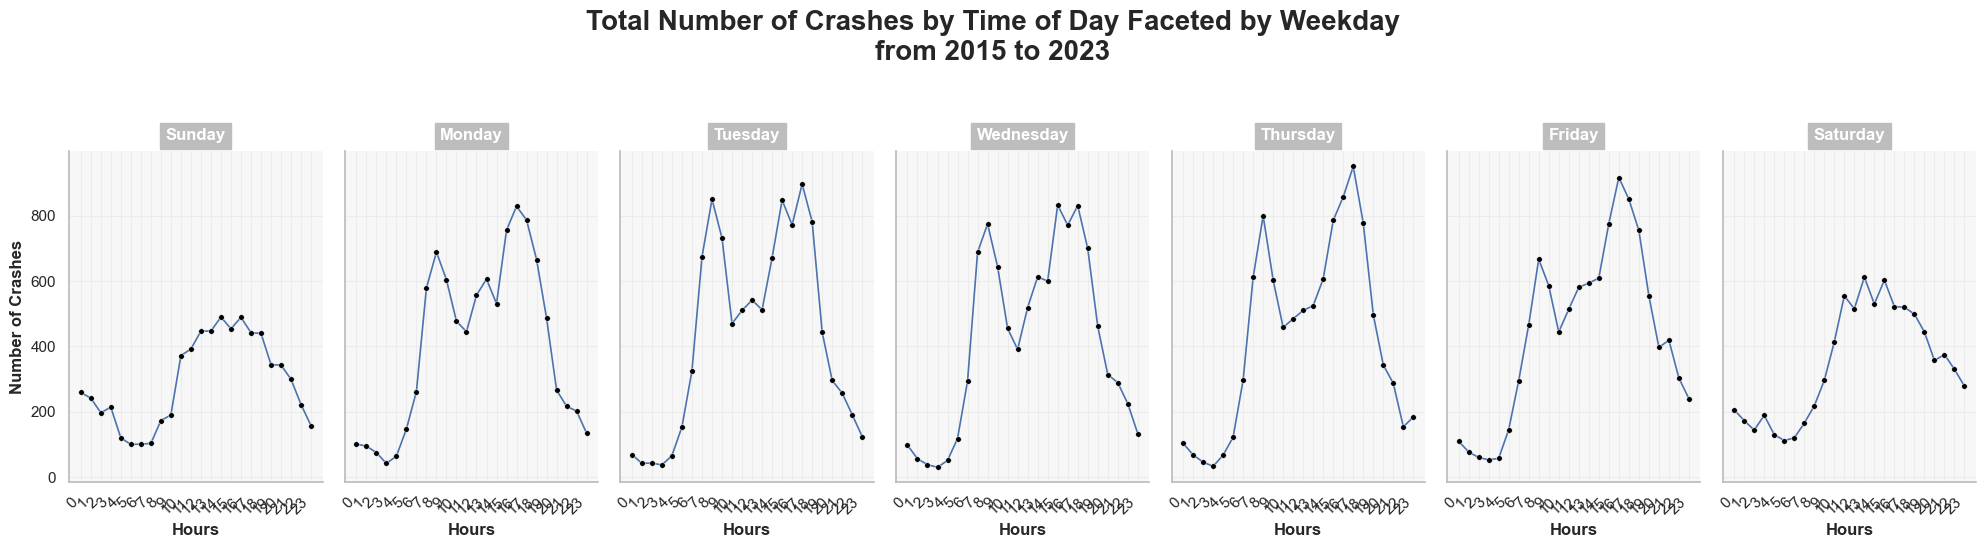

In [307]:

DATE_COL = "Crash Date/Time"  # change if needed
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL])

# Filter years (2015–2023)
df["Year"] = df[DATE_COL].dt.year
df = df[(df["Year"] >= 2015) & (df["Year"] <= 2023)]

# ----------------------------
# Extract hour + weekday
# ----------------------------
df["Hour"] = df[DATE_COL].dt.hour

# Pandas: Monday=0 ... Sunday=6
df["Weekday"] = df[DATE_COL].dt.dayofweek

weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
weekday_map = {6: "Sunday", 0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday"}

df["WeekdayName"] = df["Weekday"].map(weekday_map)
df["WeekdayName"] = pd.Categorical(df["WeekdayName"], categories=weekday_order, ordered=True)

# ----------------------------
# Count crashes by (weekday, hour)
# ----------------------------
hourly_weekday = (
    df.groupby(["WeekdayName", "Hour"])
      .size()
      .reset_index(name="Crashes")
)

# Fill missing hour bins (0..23) for each weekday with zero
full_index = pd.MultiIndex.from_product([weekday_order, range(24)], names=["WeekdayName", "Hour"])
hourly_weekday = (
    hourly_weekday.set_index(["WeekdayName", "Hour"])
                 .reindex(full_index, fill_value=0)
                 .reset_index()
)

# ----------------------------
# Plot (ggplot-like, faceted by weekday)
# ----------------------------
sns.set_theme(
    style="whitegrid",
    rc={
        "axes.facecolor": "#f7f7f7",
        "grid.color": "#e6e6e6",
        "grid.linewidth": 0.8,
        "axes.edgecolor": "#bdbdbd",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
    }
)

g = sns.FacetGrid(
    hourly_weekday,
    col="WeekdayName",
    col_wrap=7,     # one row like your example
    height=5.2,
    aspect=0.55,
    sharey=True
)

# Line + black points
g.map_dataframe(
    sns.lineplot,
    x="Hour",
    y="Crashes",
    color="#4C72B0",
    linewidth=1.2
)

g.map_dataframe(
    sns.scatterplot,
    x="Hour",
    y="Crashes",
    color="black",
    s=16,
    zorder=3
)

# Axis labels/ticks
g.set_axis_labels("Hours", "Number of Crashes")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(24))
    ax.set_xticklabels([str(h) for h in range(24)], rotation=45, ha="right")
    ax.grid(True, axis="both", alpha=0.6)

# Grey facet headers like ggplot
for ax in g.axes.flat:
    ax.set_title(
        ax.get_title(),
        backgroundcolor="#bdbdbd",
        color="white",
        fontsize=12,
        pad=8
    )

g.fig.suptitle(
    "Total Number of Crashes by Time of Day Faceted by Weekday\nfrom 2015 to 2023",
    fontsize=20,
    weight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()

### 3.3 Collision Causes
#### 3.3.1 Driver Substance Abuse


In [308]:
substance_pct = df["Driver Substance Abuse"].value_counts(normalize=True).mul(100).round(2)
substance_pct


Driver Substance Abuse
NONE DETECTED                 71.79
Missing/Unknown               17.89
UNKNOWN                        6.70
ALCOHOL PRESENT                2.34
ALCOHOL CONTRIBUTED            0.83
ILLEGAL DRUG PRESENT           0.17
MEDICATION PRESENT             0.07
ILLEGAL DRUG CONTRIBUTED       0.06
COMBINED SUBSTANCE PRESENT     0.06
MEDICATION CONTRIBUTED         0.04
COMBINATION CONTRIBUTED        0.03
OTHER                          0.02
Name: proportion, dtype: float64

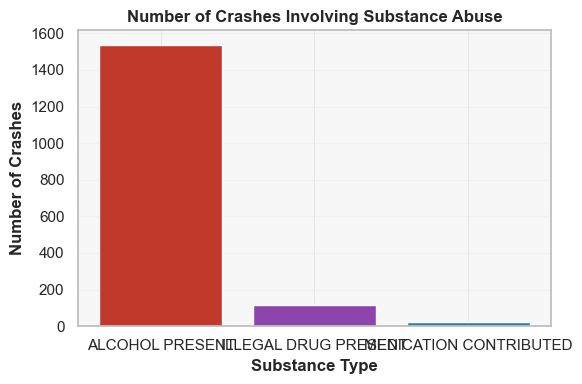

In [309]:
substance_df = df[df["Driver Substance Abuse"].isin(
    ["ALCOHOL PRESENT" , "ILLEGAL DRUG PRESENT" , "MEDICATION CONTRIBUTED" ]
)]

# Count crashes by substance type
counts = substance_df["Driver Substance Abuse"].value_counts()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(
    counts.index,
    counts.values,
    color=["#c0392b", "#8e44ad", "#2980b9"]
)

plt.title("Number of Crashes Involving Substance Abuse")
plt.xlabel("Substance Type")
plt.ylabel("Number of Crashes")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


#### 3.3.2 Driver Distraction


In [310]:
# Group distraction into broader categories
def categorize_distraction(val):
    v = str(val).lower()
    if "not distracted" in v:
        return "Not Distracted"
    if "inattention" in v or "looked but did not see" in v:
        return "Inattention"
    if "phone" in v or "text" in v or "cell" in v or "other occupants" in v or "inside" in v:
        return "Internal Distraction"
    if "outside" in v or "external" in v or "pedestrian" in v or "object" in v:
        return "External Distraction"
    return "Other"

df["Distraction Group"] = df["Driver Distracted By"].apply(categorize_distraction)
distract_pct = df["Distraction Group"].value_counts(normalize=True).mul(100).round(2)
distract_pct


Distraction Group
Not Distracted          62.47
Other                   23.59
Inattention             12.50
External Distraction     0.75
Internal Distraction     0.69
Name: proportion, dtype: float64

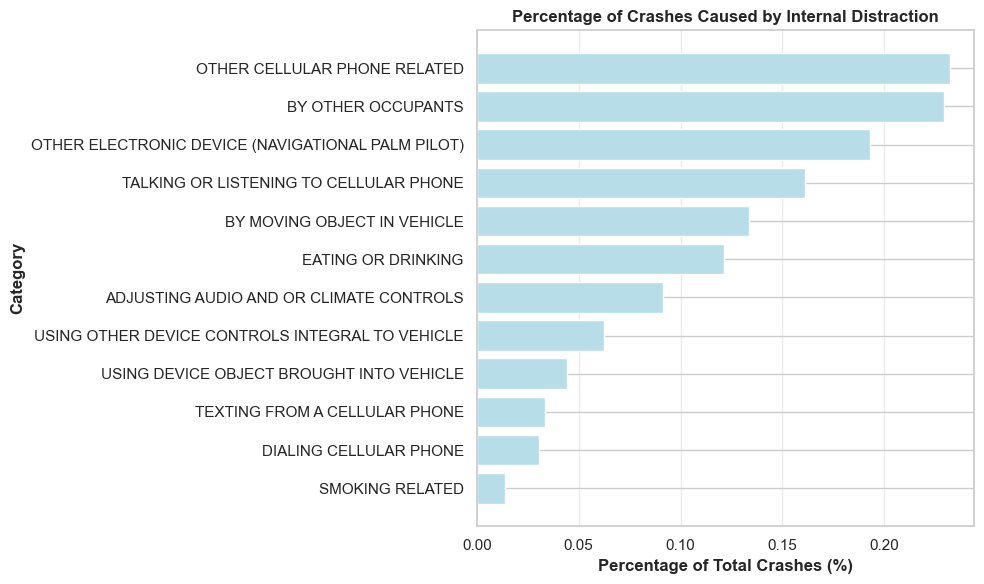

In [311]:
internal_categories = [
    "BY OTHER OCCUPANTS",
    "OTHER CELLULAR PHONE RELATED",
    "OTHER ELECTRONIC DEVICE (NAVIGATIONAL PALM PILOT)",
    "TALKING OR LISTENING TO CELLULAR PHONE",
    "BY MOVING OBJECT IN VEHICLE",
    "EATING OR DRINKING",
    "ADJUSTING AUDIO AND OR CLIMATE CONTROLS",
    "USING OTHER DEVICE CONTROLS INTEGRAL TO VEHICLE",
    "TEXTING FROM A CELLULAR PHONE",
    "USING DEVICE OBJECT BROUGHT INTO VEHICLE",
    "DIALING CELLULAR PHONE",
    "SMOKING RELATED"
]

# ----------------------------
# Filter internal distractions
# ----------------------------
internal_df = df[df["Driver Distracted By"].isin(internal_categories)]

# ----------------------------
# Compute percentage of total crashes
# ----------------------------
total_crashes = len(df)

percentages = (
    internal_df["Driver Distracted By"]
    .value_counts()
    / total_crashes
    * 100
)

percentages = percentages.sort_values(ascending=True)

# ----------------------------
# Plot
# ----------------------------
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.barh(
    percentages.index,
    percentages.values,
    color="#b7dde8"
)

plt.title("Percentage of Crashes Caused by Internal Distraction", fontsize=12, weight="bold")
plt.xlabel("Percentage of Total Crashes (%)", fontsize=12)
plt.ylabel("Category", fontsize=12)

plt.grid(axis="x", alpha=0.4)
plt.tight_layout()
plt.show()

#### 3.3.3 Vehicle Equipment Problems


In [312]:
equip_pct = df["Equipment Problems"].value_counts(normalize=True).mul(100).round(2)
equip_pct


Equipment Problems
NO MISUSE              72.16
Missing/Unknown        19.72
UNKNOWN                 7.94
AIR BAG FAILED          0.11
OTHER                   0.05
BELT(S) MISUSED         0.02
STRAP/TETHER LOOSE      0.01
BELTS/ANCHORS BROKE     0.00
SIZE/TYPE IMPROPER      0.00
NOT STREPPED RIGHT      0.00
FACING WRONG WAY        0.00
Name: proportion, dtype: float64

#### 3.3.4 Vehicle Movement (vs Vehicle Damage Extent)


In [313]:
# Collapse vehicle movement into broader categories
def movement_group(v):
    s = str(v).lower()
    if "park" in s or "stopped" in s or "stationary" in s:
        return "Stationary"
    if "turn" in s or "u turn" in s or "lane" in s:
        return "Turning"
    if "start" in s:
        return "Starting"
    if "traffic" in s or "enter" in s or "leave" in s:
        return "Traffic"
    if "skid" in s or "slow" in s or "stop" in s or "pass" in s:
        return "Maneuvering"
    return "In Motion"

df["Movement Group"] = df["Vehicle Movement"].apply(movement_group)
movement_damage = pd.crosstab(df["Movement Group"], df["Vehicle Damage Extent"], normalize="index")
movement_damage.round(3)


Vehicle Damage Extent,DESTROYED,DISABLING,FUNCTIONAL,Missing/Unknown,NO DAMAGE,OTHER,SUPERFICIAL,UNKNOWN
Movement Group,,,,,,,,
In Motion,0.063,0.438,0.220,0.002,0.030,0.001,0.198,0.048
Maneuvering,0.019,0.273,0.338,0.002,0.036,0.000,0.315,0.018
Stationary,0.009,0.152,0.343,0.002,0.042,0.001,0.428,0.025
Turning,0.038,0.392,0.260,0.001,0.052,0.000,0.224,0.033


### 3.4 Environmental Impact
#### 3.4.1 Weather Condition and Surface Condition


In [314]:
# Group weather and surface condition
def weather_group(v):
    s = str(v).lower()
    if any(k in s for k in ["rain", "snow", "fog", "sleet", "ice", "adverse"]):
        return "Adverse"
    return "Clear"

def surface_group(v):
    s = str(v).lower()
    if "dry" in s:
        return "Dry"
    if "wet" in s:
        return "Wet"
    if "snow" in s or "ice" in s:
        return "Snow/Ice"
    return "Other"

df["Weather Group"] = df["Weather"].apply(weather_group)
df["Surface Group"] = df["Surface Condition"].apply(surface_group)

ws_damage = pd.crosstab([df["Weather Group"], df["Surface Group"]], df["Vehicle Damage Extent"], normalize="index")
ws_damage.round(3).head(10)


Vehicle Damage Extent        DESTROYED  DISABLING  FUNCTIONAL  \
Weather Group Surface Group                                     
Adverse       Dry                0.011      0.460       0.253   
              Other              0.014      0.209       0.225   
              Snow/Ice           0.039      0.324       0.295   
              Wet                0.047      0.424       0.265   
Clear         Dry                0.047      0.380       0.267   
              Other              0.014      0.162       0.241   
              Snow/Ice           0.044      0.444       0.272   
              Wet                0.057      0.431       0.266   

Vehicle Damage Extent        Missing/Unknown  NO DAMAGE  OTHER  SUPERFICIAL  \
Weather Group Surface Group                                                   
Adverse       Dry                      0.000      0.011  0.000        0.241   
              Other                    0.006      0.094  0.000        0.376   
              Snow/Ice                 0.003      0.078  0.003        0.238   
              Wet                      0.001      0.027  0.000        0.211   
Clear         Dry                      0.001      0.032  0.001        0.243   
              Other                    0.005      0.076  0.001        0.393   
              Snow/Ice                 0.000      0.047  0.000        0.176   
              Wet                      0.001      0.026  0.001        0.197   

Vehicle Damage Extent        UNKNOWN  
Weather Group Surface Group           
Adverse       Dry              0.023  
              Other            0.076  
              Snow/Ice         0.021  
              Wet              0.025  
Clear         Dry              0.028  
              Other            0.109  
              Snow/Ice         0.017  
              Wet              0.022

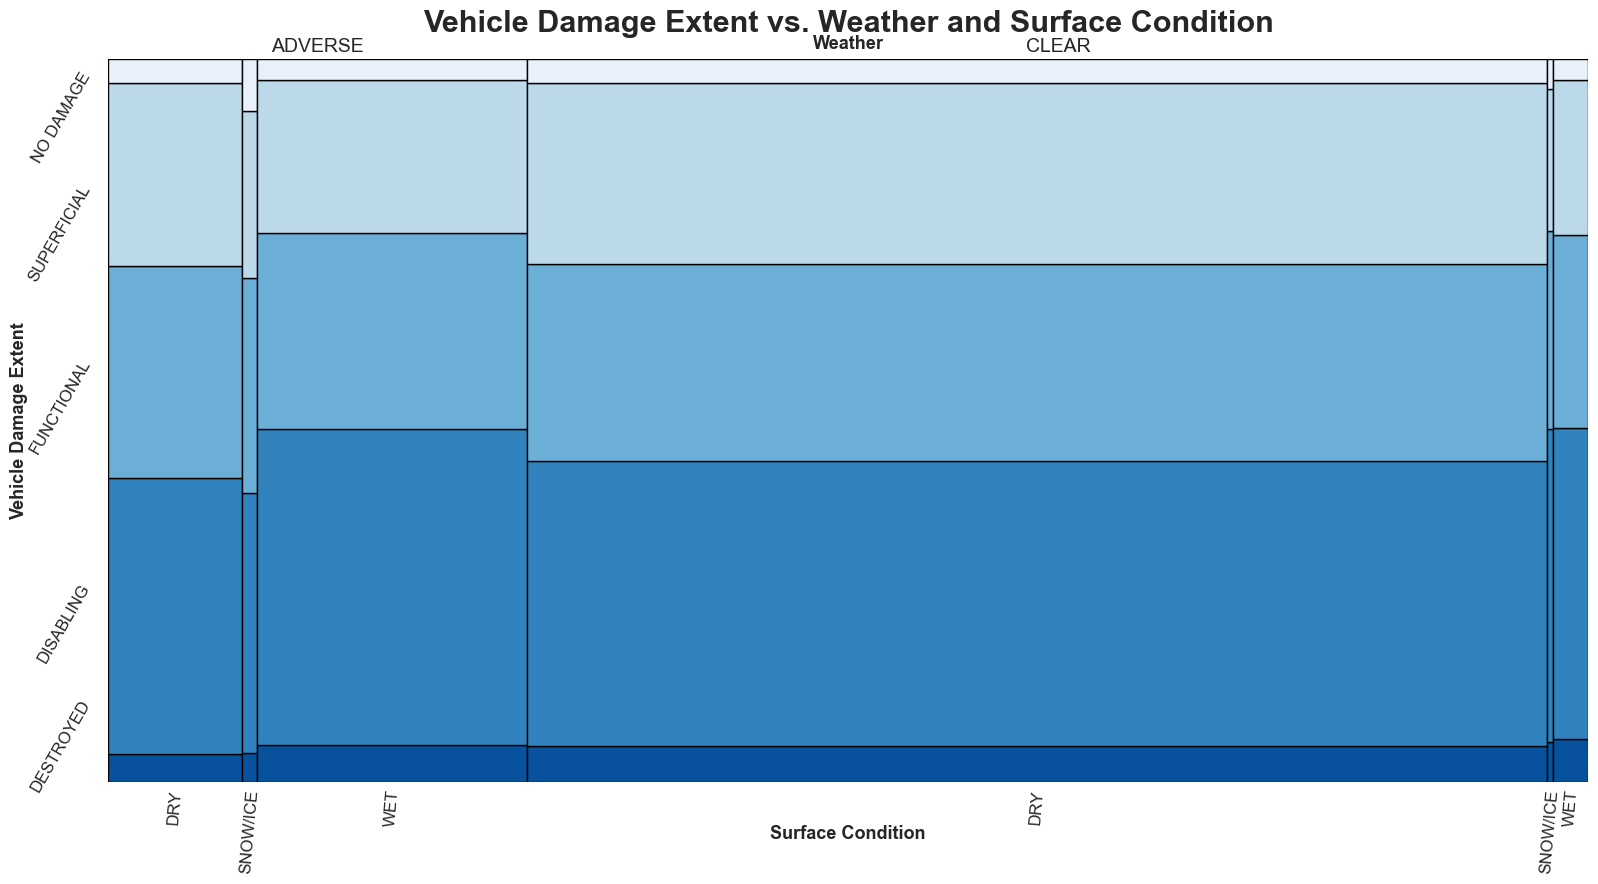

In [315]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

COL_W = "Weather"
COL_S = "Surface Condition"
COL_D = "Vehicle Damage Extent"

d = df[[COL_W, COL_S, COL_D]].copy()

# ----------------------------
# 2) Clean values
# ----------------------------
def normalize(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip().upper()
    if s in {"UNKNOWN", "MISSING/UNKNOWN", "OTHER", "N/A", "NA", ""}:
        return pd.NA
    return s

for c in [COL_W, COL_S, COL_D]:
    d[c] = d[c].apply(normalize)

d = d.dropna(subset=[COL_W, COL_S, COL_D])

# ----------------------------
# 3) Recode Weather and Surface
# ----------------------------
d["Weather2"] = d[COL_W].apply(lambda w: "CLEAR" if w == "CLEAR" else "ADVERSE")

def surface_group(s):
    s = str(s).upper()
    if "SNOW" in s or "ICE" in s:
        return "SNOW/ICE"
    if "WET" in s or "SLUSH" in s or "WATER" in s:
        return "WET"
    return "DRY"

d["Surface2"] = d[COL_S].apply(surface_group)

# Keep only the 5 real damage categories 
damage_order = ["DESTROYED", "DISABLING", "FUNCTIONAL", "SUPERFICIAL", "NO DAMAGE"]
d = d[d[COL_D].isin(damage_order)].copy()

# Order (to match your plot)
weather_order = ["ADVERSE", "CLEAR"]
surface_order = ["DRY", "SNOW/ICE", "WET"]

# ----------------------------
# 4) Build contingency table
# ----------------------------
# counts[w, s, dmg]
counts = (
    d.groupby(["Weather2", "Surface2", COL_D])
     .size()
     .reindex(pd.MultiIndex.from_product([weather_order, surface_order, damage_order],
                                         names=["Weather2", "Surface2", COL_D]),
              fill_value=0)
)

total = counts.sum()

# widths for Weather blocks (overall proportion)
weather_totals = counts.groupby(level=0).sum()
weather_width = {w: weather_totals[w] / total for w in weather_order}

# within each Weather: widths for Surface blocks (conditional proportion)
surface_width = {}
for w in weather_order:
    w_total = weather_totals[w]
    for s in surface_order:
        ws_total = counts.loc[(w, s)].sum()
        surface_width[(w, s)] = (ws_total / w_total) if w_total > 0 else 0

# within each (Weather, Surface): heights for Damage stacks (conditional proportion)
damage_height = {}
for w in weather_order:
    for s in surface_order:
        ws_total = counts.loc[(w, s)].sum()
        for dmg in damage_order:
            c = counts.loc[(w, s, dmg)]
            damage_height[(w, s, dmg)] = (c / ws_total) if ws_total > 0 else 0

# ----------------------------
# 5) Colors (blue gradient like your example)
# ----------------------------
colors = {
    "NO DAMAGE":   "#e8f1fa",
    "SUPERFICIAL": "#bcd9ea",
    "FUNCTIONAL":  "#6baed6",
    "DISABLING":   "#3182bd",
    "DESTROYED":   "#08519c",
}

# ----------------------------
# 6) Draw mosaic manually
# ----------------------------
fig, ax = plt.subplots(figsize=(16, 9))

x0 = 0.0
weather_bounds = {}   # store for labeling top
surface_centers = {}  # store for bottom labels

for w in weather_order:
    w_w = weather_width[w]
    x1 = x0 + w_w
    weather_bounds[w] = (x0, x1)

    sx0 = x0
    for s in surface_order:
        s_w = w_w * surface_width[(w, s)]
        sx1 = sx0 + s_w

        # stack damage vertically inside this (w,s) rectangle
        y0 = 0.0
        for dmg in damage_order:  # bottom -> top
            h = damage_height[(w, s, dmg)]
            if h > 0:
                rect = Rectangle(
                    (sx0, y0), s_w, h,
                    facecolor=colors[dmg],
                    edgecolor="black",
                    linewidth=1
                )
                ax.add_patch(rect)
                y0 += h

        # center for surface label (only if this block exists)
        if s_w > 0:
            surface_centers[(w, s)] = (sx0 + sx1) / 2

        sx0 = sx1

    x0 = x1

# Axes formatting (clean like the R plot)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Title
ax.set_title("Vehicle Damage Extent vs. Weather and Surface Condition",
             fontsize=22, weight="bold", pad=20)

# Top Weather labels
ax.text(0.5, 1.01, "Weather", ha="center", va="bottom",
        transform=ax.transAxes, fontsize=13, weight="bold")

for w in weather_order:
    a, b = weather_bounds[w]
    ax.text((a + b) / 2, 1.005, w, ha="center", va="bottom",
            transform=ax.transAxes, fontsize=14)

# Bottom Surface labels
ax.text(0.5, -0.06, "Surface Condition", ha="center", va="top",
        transform=ax.transAxes, fontsize=13, weight="bold")

for w in weather_order:
    for s in surface_order:
        if (w, s) in surface_centers:
            ax.text(surface_centers[(w, s)], -0.01, s,
                    ha="center", va="top", rotation=85,
                    transform=ax.transAxes, fontsize=12)

# Left Damage labels (top -> bottom like your screenshot)
ax.text(-0.06, 0.5, "Vehicle Damage Extent",
        ha="center", va="center", rotation=90,
        transform=ax.transAxes, fontsize=13, weight="bold")

# Place labels at approximate band centers using global proportions
# (looks like the R plot and stays stable)
y_positions = {
    "NO DAMAGE":   0.92,
    "SUPERFICIAL": 0.76,
    "FUNCTIONAL":  0.52,
    "DISABLING":   0.22,
    "DESTROYED":   0.05
}
for dmg, yp in y_positions.items():
    ax.text(-0.01, yp, dmg, ha="right", va="center",
            rotation=60, transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.show()


#### 3.4.2 Speed Limit (binned) vs Vehicle Damage Extent


In [316]:
# Speed limit bins with 55+
if "Speed Limit" in df.columns:
    def speed_bin(x):
        try:
            x = float(x)
        except Exception:
            return "Unknown"
        if x >= 55:
            return "55+"
        return str(int(x))
    df["Speed Bin"] = df["Speed Limit"].apply(speed_bin)
    speed_damage = pd.crosstab(df["Speed Bin"], df["Vehicle Damage Extent"], normalize="index")
speed_damage.round(3).head(10)


Vehicle Damage Extent,DESTROYED,DISABLING,FUNCTIONAL,Missing/Unknown,NO DAMAGE,OTHER,SUPERFICIAL,UNKNOWN
Speed Bin,,,,,,,,
0,0.007,0.114,0.258,0.004,0.095,0.002,0.434,0.086
10,0.006,0.119,0.239,0.003,0.087,0.001,0.435,0.109
15,0.007,0.158,0.247,0.002,0.076,0.000,0.404,0.105
20,0.020,0.286,0.256,0.004,0.064,0.002,0.302,0.066
25,0.034,0.328,0.245,0.002,0.061,0.000,0.284,0.044
30,0.045,0.394,0.266,0.002,0.037,0.001,0.225,0.030
35,0.042,0.382,0.274,0.002,0.026,0.001,0.246,0.028
40,0.059,0.422,0.272,0.002,0.018,0.001,0.206,0.021
45,0.061,0.434,0.262,0.001,0.018,0.001,0.207,0.017


#### 3.4.3 Light Condition and Traffic Control vs Injury Severity


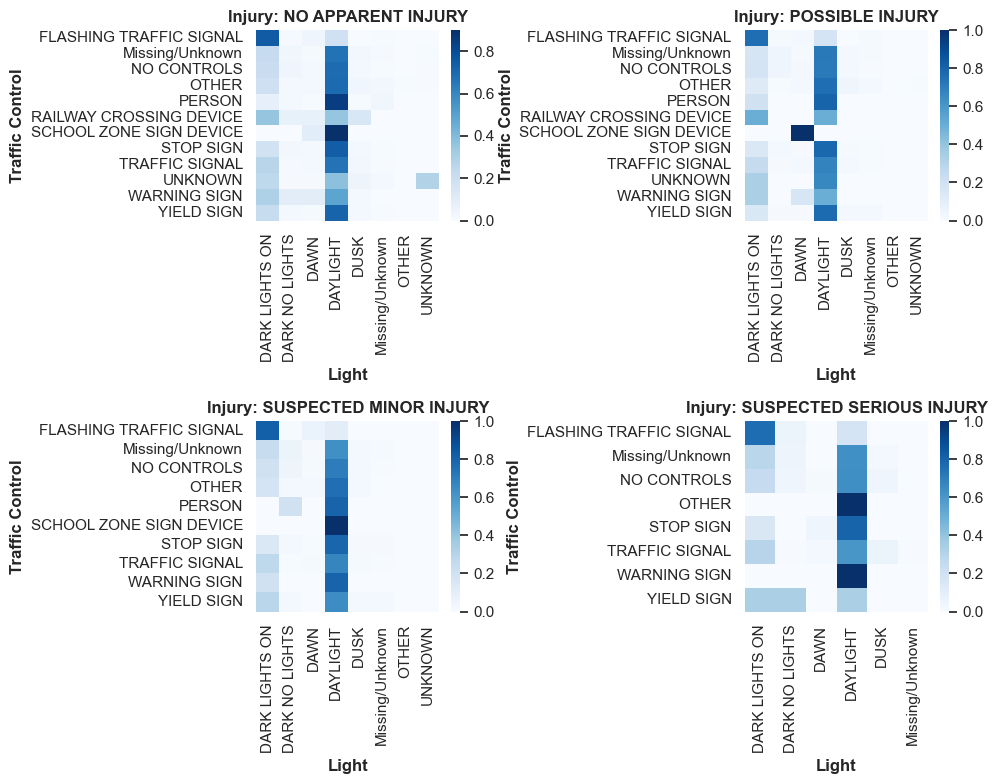

In [317]:
# Heatmaps by injury severity
injury_levels = df["Injury Severity"].value_counts().index[:4]
fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten()
for ax, level in zip(axes, injury_levels):
    sub = df[df["Injury Severity"] == level]
    ct = pd.crosstab(sub["Traffic Control"], sub["Light"], normalize="index")
    sns.heatmap(ct, ax=ax, cmap="Blues")
    ax.set_title(f"Injury: {level}")
    ax.set_xlabel("Light")
    ax.set_ylabel("Traffic Control")
plt.tight_layout()
plt.show()


#### 3.4.4 Chi-Square Tests


In [318]:
try:
    from scipy.stats import chi2_contingency
    tests = []
    indep_vars = ["Surface Condition", "Weather", "Traffic Control", "Light", "Speed Limit"]
    for y in ["Vehicle Damage Extent", "Injury Severity"]:
        for x in indep_vars:
            if x in df.columns and y in df.columns:
                ct = pd.crosstab(df[x], df[y])
                chi2, p, dof, _ = chi2_contingency(ct)
                tests.append({"Dependent": y, "Independent": x, "p_value": p, "Significant(p<0.01)": p < 0.01})
    chi_table = pd.DataFrame(tests)
except Exception as e:
    print("Chi-square tests skipped:", e)
print(chi_table)

               Dependent        Independent        p_value  \
0  Vehicle Damage Extent  Surface Condition   0.000000e+00   
1  Vehicle Damage Extent            Weather  4.266133e-218   
2  Vehicle Damage Extent    Traffic Control  1.472605e-294   
3  Vehicle Damage Extent              Light   0.000000e+00   
4  Vehicle Damage Extent        Speed Limit   0.000000e+00   
5        Injury Severity  Surface Condition  6.337139e-123   
6        Injury Severity            Weather   8.243496e-05   
7        Injury Severity    Traffic Control   1.838438e-79   
8        Injury Severity              Light   2.871353e-14   
9        Injury Severity        Speed Limit  3.412974e-234   

   Significant(p<0.01)  
0                 True  
1                 True  
2                 True  
3                 True  
4                 True  
5                 True  
6                 True  
7                 True  
8                 True  
9                 True  


### 3.5 Vehicle Condition
#### 3.5.1 Vehicle Age


In [319]:
# Cleaning the abnormal values in Vehicle Year
df["Crash Date/Time"] = pd.to_datetime(df["Crash Date/Time"], errors="coerce")                                                       
crash_year = df["Crash Date/Time"].dt.year                                                                                           
vy = pd.to_numeric(df["Vehicle Year"], errors="coerce")                                                                              
                                                                                                                                     
# bad year -> missing                                                                                                                
bad = vy.isna() | (vy < 1900) | (vy > (crash_year + 1))                                                                              
df["Vehicle Year Clean"] = vy.mask(bad)                                                                                              
                                                                                                                                     
# derive age                                                                                                                         
df["Vehicle Age"] = crash_year - df["Vehicle Year Clean"]                                                                            
df.loc[(df["Vehicle Age"] < 0) | (df["Vehicle Age"] > 50), "Vehicle Age"] = np.nan 

In [320]:
# Check how many missing after cleaning
missing_after = df["Vehicle Year Clean"].isna().mean() * 100
print(f"Missing % in Vehicle Year after cleaning: {missing_after:.2f}%")

Missing % in Vehicle Year after cleaning: 2.29%


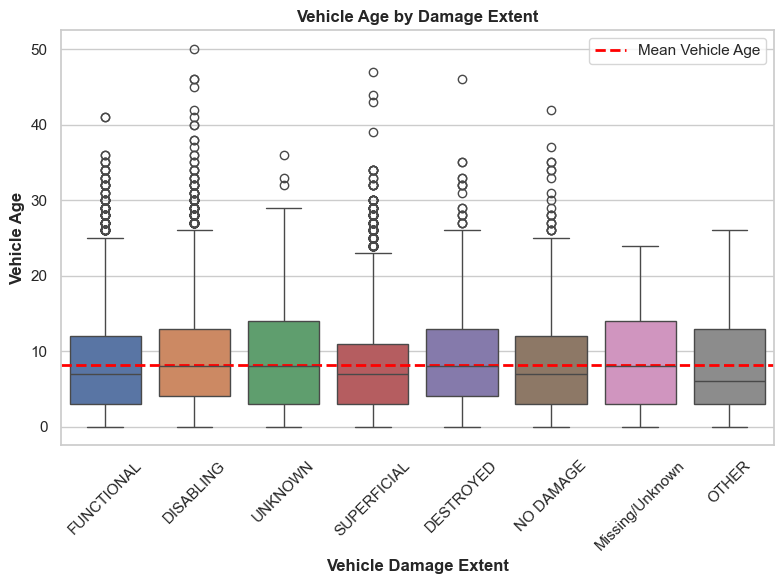

In [321]:
#Visualize vehicle age by damage extent
# Wuth mean
plt.figure(figsize=(8, 6))
sns.boxplot(x="Vehicle Damage Extent",y="Vehicle Age",data=df,hue="Vehicle Damage Extent")

# Compute overall mean vehicle age
mean_age = df["Vehicle Age"].mean()

# Add red horizontal line for the mean
plt.axhline(y=mean_age,color="red",linestyle="--",linewidth=2,label="Mean Vehicle Age")

plt.title("Vehicle Age by Damage Extent")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [322]:
from scipy.stats import kruskal                                                                                                      
import numpy as np                                                                                                                   
                                                                                                                                     
sub = df.dropna(subset=["Vehicle Age"]).copy()                                                                                       
sub = sub[~sub["Vehicle Damage Extent"].isin(["UNKNOWN", "Missing/Unknown", "OTHER"])]                                               
                                                                                                                                     
grouped = [g["Vehicle Age"].values for _, g in sub.groupby("Vehicle Damage Extent")]                                                 
H, p = kruskal(*grouped)                                                                                                             
                                                                                                                                     
n = len(sub)                                                                                                                         
k = sub["Vehicle Damage Extent"].nunique()                                                                                           
eps2 = (H - k + 1) / (n - k)                                                                                                         
                                                                                                                                     
print(f"Kruskal H={H:.3f}, p={p:.4g}, epsilon^2={eps2:.4f}")          

Kruskal H=280.383, p=1.842e-59, epsilon^2=0.0044


#### 3.5.2 Vehicle Size


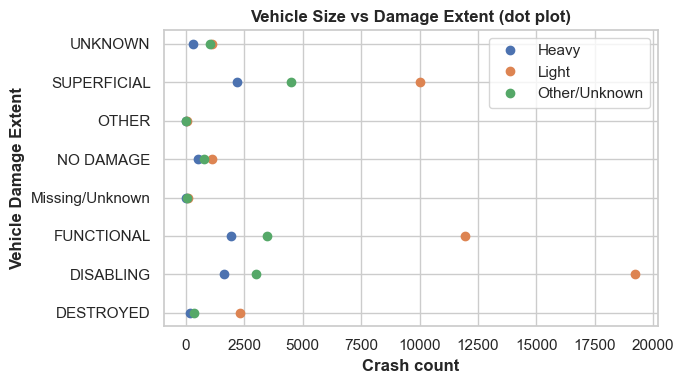

In [324]:
# Categorize vehicle body types into size groups
def size_group(v):
    s = str(v).lower()
    if any(k in s for k in ["motorcycle", "moped"]):
        return "Light"
    if any(k in s for k in ["passenger", "sedan", "coupe", "hatch", "convertible"]):
        return "Light"
    if any(k in s for k in ["van", "suv", "pickup", "truck"]):
        return "Heavy"
    return "Other/Unknown"

df["Vehicle Size"] = df["Vehicle Body Type"].apply(size_group)
size_damage = df.groupby(["Vehicle Size", "Vehicle Damage Extent"]).size().reset_index(name="count")

# Cleveland dot plot
plt.figure(figsize=(7,4))
for size in size_damage["Vehicle Size"].unique():
    sub = size_damage[size_damage["Vehicle Size"] == size]
    plt.plot(sub["count"], sub["Vehicle Damage Extent"], "o", label=size)
plt.title("Vehicle Size vs Damage Extent (dot plot)")
plt.xlabel("Crash count")
plt.ylabel("Vehicle Damage Extent")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Predictive Modeling and Validation


In [326]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Data Preparation ---
# Define Target: Serious Injury
serious_mask = ['FATAL INJURY', 'SUSPECTED SERIOUS INJURY']
df['Is_Serious'] = df['Injury Severity'].isin(serious_mask).astype(int)

# Select predictors and handle missing values
cols_to_use = ['Weather', 'Surface Condition', 'Light']
model_df = df[cols_to_use + ['Is_Serious']].copy()

# Simple cleaning: group unknown/missing into the most frequent category
for col in cols_to_use:
    most_freq = model_df[col].mode()[0]
    model_df[col] = model_df[col].replace(['Missing/Unknown', 'UNKNOWN', 'OTHER'], most_freq)

# --- Create Model Matrix (The Robust Way) ---
# This replaces the formula 'Is_Serious ~ C(Weather) + ...'
X = pd.get_dummies(model_df[cols_to_use], drop_first=True).astype(float)
X = sm.add_constant(X) # Don't forget the intercept!
y = model_df['Is_Serious']

# --- Fit Model 1 ---
logit_mod1 = sm.Logit(y, X).fit()
print(logit_mod1.summary())

# --- Model Comparison (Requirement C) ---
# Create a "Reduced Model" (e.g., without Weather) to compare
X_reduced = X.drop([c for c in X.columns if 'Weather' in c], axis=1)
logit_mod_reduced = sm.Logit(y, X_reduced).fit()

print(f"\nFull Model AIC: {logit_mod1.aic}")
print(f"Reduced Model AIC: {logit_mod_reduced.aic}")
print(f"Difference in AIC: {logit_mod_reduced.aic - logit_mod1.aic}")
# Interpretation: Lower AIC is better.


         Current function value: 0.051518
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             Is_Serious   No. Observations:                65842
Model:                          Logit   Df Residuals:                    65820
Method:                           MLE   Df Model:                           21
Date:                Sun, 15 Feb 2026   Pseudo R-squ.:                0.005686
Time:                        17:48:40   Log-Likelihood:                -3392.0
converged:                      False   LL-Null:                       -3411.4
Covariance Type:            nonrobust   LLR p-value:                   0.01038
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                      -15.9042   1427.099     -0.011      0.991

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.051585
         Iterations: 35

Full Model AIC: 6828.041142892085
Reduced Model AIC: 6818.966588946027
Difference in AIC: -9.074553946058586


c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [327]:
# Calculate Odds Ratios
odds_ratios = np.exp(logit_mod1.params)
conf = np.exp(logit_mod1.conf_int())
conf.columns = ['Lower 95%', 'Upper 95%']

or_table = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    'Lower 95%': conf['Lower 95%'],
    'Upper 95%': conf['Upper 95%']
})

print("\n--- Odds Ratios and Confidence Intervals ---")
print(or_table)


--- Odds Ratios and Confidence Intervals ---
                                            Odds Ratio  Lower 95%  Upper 95%
const                                     1.238511e-07   0.000000        inf
Weather_BLOWING SNOW                      2.528791e+05   0.000000        inf
Weather_CLEAR                             9.182820e+04   0.000000        inf
Weather_CLOUDY                            9.674584e+04   0.000000        inf
Weather_FOGGY                             6.323005e+04   0.000000        inf
Weather_RAINING                           7.133716e+04   0.000000        inf
Weather_SEVERE WINDS                      3.570318e-01   0.000000        inf
Weather_SLEET                             2.012685e+05   0.000000        inf
Weather_SNOW                              3.945011e+04   0.000000        inf
Weather_WINTRY MIX                        2.122203e+05   0.000000        inf
Surface Condition_ICE                     1.134625e+00   0.453931   2.836060
Surface Condition_MUD, DIRT, G

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [328]:
# Calculate VIF for the model matrix (excluding the constant)
vif_data = pd.DataFrame()
X_vif = X.drop('const', axis=1)
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print("\n--- Variance Inflation Factor (VIF) ---")
print(vif_data.sort_values(by="VIF", ascending=False))



--- Variance Inflation Factor (VIF) ---
                                     feature       VIF
19                            Light_DAYLIGHT  4.070842
4                            Weather_RAINING  3.546943
1                              Weather_CLEAR  3.530153
16                     Surface Condition_WET  3.313825
7                               Weather_SNOW  1.780060
14                    Surface Condition_SNOW  1.700509
2                             Weather_CLOUDY  1.604167
9                      Surface Condition_ICE  1.153358
8                         Weather_WINTRY MIX  1.133197
17                      Light_DARK NO LIGHTS  1.131172
20                                Light_DUSK  1.101111
18                                Light_DAWN  1.091613
3                              Weather_FOGGY  1.046975
6                              Weather_SLEET  1.041293
13                   Surface Condition_SLUSH  1.030767
0                       Weather_BLOWING SNOW  1.013544
15  Surface Condition_WA

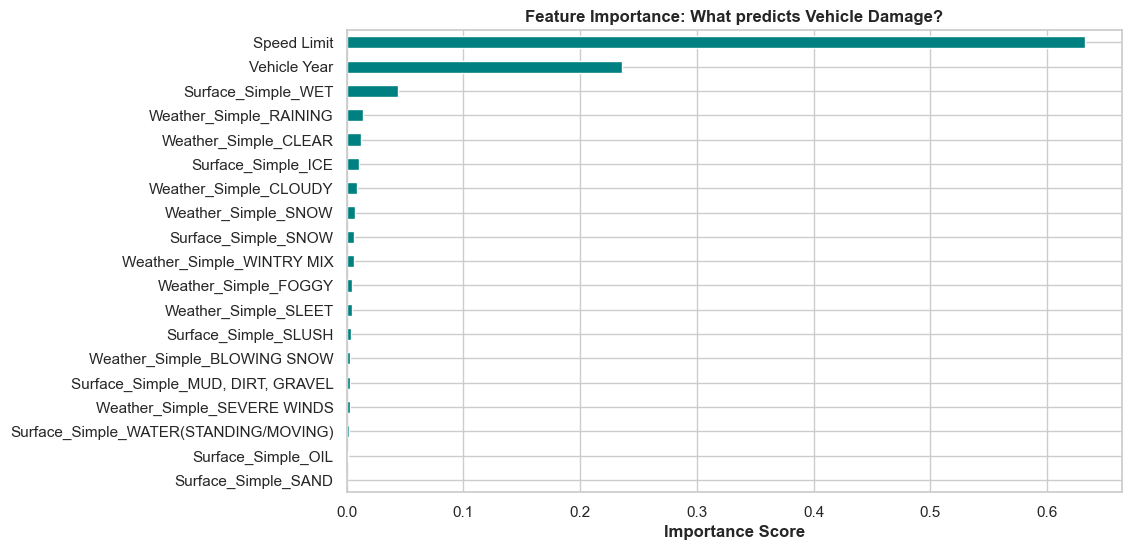

In [330]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
# 1. Clean Data for RF (Handle outliers in Vehicle Year)
rf_df = df[(df['Vehicle Year'] > 1990) & (df['Vehicle Year'] < 2025)].copy()
rf_df = rf_df[rf_df['Vehicle Damage Extent'] != 'Missing/Unknown'].dropna(subset=['Vehicle Damage Extent'])
# 2. Encode categorical variables
le = LabelEncoder()
rf_df['Damage_Target'] = le.fit_transform(rf_df['Vehicle Damage Extent'])
# Features: Mixture of numeric and categorical (encoded)
features = ['Vehicle Year', 'Speed Limit', 'Weather_Simple', 'Surface_Simple']
X_rf = pd.get_dummies(rf_df[features], drop_first=True)
y_rf = rf_df['Damage_Target']
# 3. Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_rf, y_rf)
# 4. Plot Feature Importance (Requirement D)
import matplotlib.pyplot as plt
importances = pd.Series(rf.feature_importances_, index=X_rf.columns).sort_values()
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title("Feature Importance: What predicts Vehicle Damage?")
plt.xlabel("Importance Score")
plt.show()